In [12]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

BASE = "/kaggle/input/the-blind-flight-synapse-drive-ps-1/SynapseDrive_Dataset"

print("BASE contents:")
print(os.listdir(BASE))

print("\nTRAIN contents:")
print(os.listdir(f"{BASE}/train"))

print("\nTEST contents:")
print(os.listdir(f"{BASE}/test"))

print("\nTRAIN images:", len(os.listdir(f"{BASE}/train/images")))
print("TRAIN labels:", len(os.listdir(f"{BASE}/train/labels")))
print("TRAIN velocities:", len(os.listdir(f"{BASE}/train/velocities")))

print("\nTEST images:", len(os.listdir(f"{BASE}/test/images")))
print("TEST velocities:", len(os.listdir(f"{BASE}/test/velocities")))


BASE contents:
['assets', 'sample_code.ipynb', 'submission_baseline.csv', 'test', 'train']

TRAIN contents:
['labels', 'images', 'velocities']

TEST contents:
['images', 'velocities']

TRAIN images: 20
TRAIN labels: 20
TRAIN velocities: 20

TEST images: 10000
TEST velocities: 10000


In [13]:
SAMPLE_ID = "0001"

# Load image
img = cv2.imread(f"{BASE}/train/images/{SAMPLE_ID}.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load label grid
with open(f"{BASE}/train/labels/{SAMPLE_ID}.json", "r") as f:
    label_data = json.load(f)

grid = np.array(label_data["grid"])

# Load velocity
with open(f"{BASE}/train/velocities/{SAMPLE_ID}.json", "r") as f:
    vel_data = json.load(f)

boost = np.array(vel_data["boost"])

print("Image shape :", img.shape)
print("Grid shape  :", grid.shape)
print("Boost shape :", boost.shape)

print("Classes present:", np.unique(grid))
print("START count:", np.sum(grid == 3))
print("GOAL  count:", np.sum(grid == 4))


Image shape : (1385, 1385, 3)
Grid shape  : (20, 20)
Boost shape : (20, 20)
Classes present: [0 1 2 3 4]
START count: 1
GOAL  count: 1


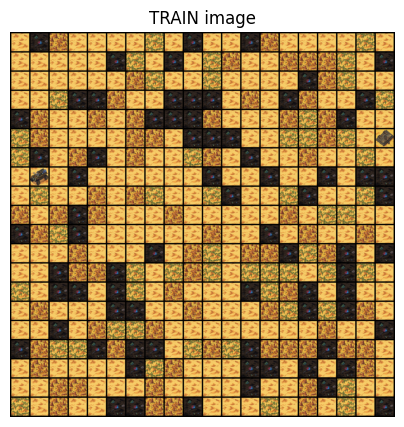

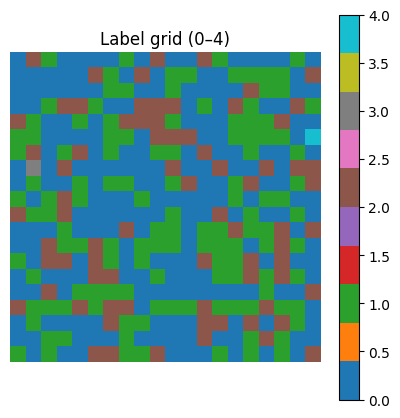

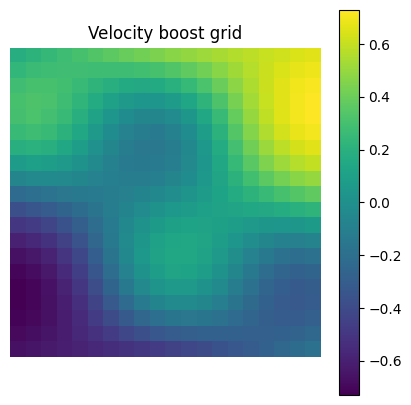

In [14]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title("TRAIN image")
plt.axis("off")
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(grid, cmap="tab10")
plt.colorbar()
plt.title("Label grid (0–4)")
plt.axis("off")
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(boost, cmap="viridis")
plt.colorbar()
plt.title("Velocity boost grid")
plt.axis("off")
plt.show()


In [ ]:
#terrain identifier

In [20]:
# STEP 1A: Load TRUE terrain labels from TRAIN JSON

terrain_map = {
    "desert": 0,
    "lab": 1,
    "forest": 2
}

terrain_images = []
terrain_labels = []

train_img_dir = f"{BASE}/train/images"
train_lbl_dir = f"{BASE}/train/labels"

image_files = sorted(os.listdir(train_img_dir))

for fname in image_files:
    img_id = fname.split(".")[0]

    # image
    img = cv2.imread(f"{train_img_dir}/{fname}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))

    # label json
    with open(f"{train_lbl_dir}/{img_id}.json", "r") as f:
        label_data = json.load(f)

    terrain_str = label_data["terrain"]
    terrain_lbl = terrain_map[terrain_str]

    terrain_images.append(img)
    terrain_labels.append(terrain_lbl)

terrain_images = np.array(terrain_images)
terrain_labels = np.array(terrain_labels)

print("Terrain dataset shape:", terrain_images.shape)
print("Terrain label counts:", np.bincount(terrain_labels))


Terrain dataset shape: (20, 128, 128, 3)
Terrain label counts: [10  2  8]


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class TerrainDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.tf = T.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.tf(self.images[idx]), self.labels[idx]

terrain_ds = TerrainDataset(terrain_images, terrain_labels)
terrain_loader = DataLoader(
    terrain_ds,
    batch_size=8,
    shuffle=True
)

print("Terrain dataset size:", len(terrain_ds))


Terrain dataset size: 20


In [22]:
class TerrainCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 64×64

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 32×32

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 16×16

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 8×8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3)   # desert / lab / forest
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


device = "cuda" if torch.cuda.is_available() else "cpu"
terrain_model = TerrainCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(terrain_model.parameters(), lr=1e-4)

print("High-capacity Terrain CNN initialized on:", device)


High-capacity Terrain CNN initialized on: cuda


In [23]:
EPOCHS = 15

for epoch in range(EPOCHS):
    terrain_model.train()
    correct = 0
    total = 0
    loss_sum = 0.0

    for x, y in terrain_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = terrain_model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Loss {loss_sum:.4f} | "
        f"Accuracy {correct/total:.4f}"
    )


Epoch 01 | Loss 4.3968 | Accuracy 0.4000
Epoch 02 | Loss 0.8816 | Accuracy 0.9000
Epoch 03 | Loss 0.4824 | Accuracy 0.9500
Epoch 04 | Loss 0.1878 | Accuracy 1.0000
Epoch 05 | Loss 0.2060 | Accuracy 1.0000
Epoch 06 | Loss 0.1515 | Accuracy 1.0000
Epoch 07 | Loss 0.0105 | Accuracy 1.0000
Epoch 08 | Loss 0.0047 | Accuracy 1.0000
Epoch 09 | Loss 0.0108 | Accuracy 1.0000
Epoch 10 | Loss 0.0160 | Accuracy 1.0000
Epoch 11 | Loss 0.0038 | Accuracy 1.0000
Epoch 12 | Loss 0.0065 | Accuracy 1.0000
Epoch 13 | Loss 0.0026 | Accuracy 1.0000
Epoch 14 | Loss 0.0035 | Accuracy 1.0000
Epoch 15 | Loss 0.0090 | Accuracy 1.0000


In [ ]:
#checking the trained terrain classifier CNN

In [24]:
terrain_model.eval()

test_id = image_files[0]   # any TRAIN image
img = cv2.imread(f"{train_img_dir}/{test_id}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))

x = T.ToTensor()(img).unsqueeze(0).to(device)

with torch.no_grad():
    pred = terrain_model(x).argmax(1).item()

terrain_map = {0: "desert", 1: "lab", 2: "forest"}
print("Predicted terrain:", terrain_map[pred])


Predicted terrain: desert


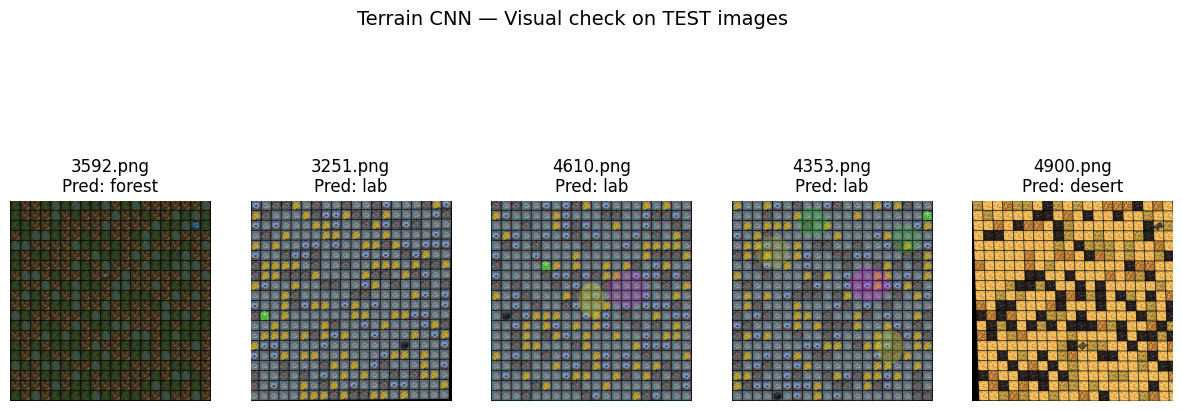

In [25]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Terrain label mapping
terrain_map = {0: "desert", 1: "lab", 2: "forest"}

test_img_dir = f"{BASE}/test/images"
test_files = sorted(os.listdir(test_img_dir))

# Pick 5 random test images
random_test_files = random.sample(test_files, 5)

terrain_model.eval()

plt.figure(figsize=(15, 6))

for i, fname in enumerate(random_test_files):
    img = cv2.imread(f"{test_img_dir}/{fname}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Prepare input
    img_resized = cv2.resize(img, (128, 128))
    x = T.ToTensor()(img_resized).unsqueeze(0).to(device)

    # Predict terrain
    with torch.no_grad():
        pred = terrain_model(x).argmax(1).item()

    pred_terrain = terrain_map[pred]

    # Show image
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{fname}\nPred: {pred_terrain}")
    plt.axis("off")

plt.suptitle("Terrain CNN — Visual check on TEST images", fontsize=14)
plt.show()


In [ ]:
#terrain specific tile CNN data preparation 

In [26]:
# STEP 2A: Containers for terrain-specific tile datasets

TILE_SIZE = 32  # CNN input size for tiles

tile_data = {
    0: {"images": [], "labels": []},  # desert
    1: {"images": [], "labels": []},  # lab
    2: {"images": [], "labels": []},  # forest
}

terrain_name = {0: "desert", 1: "lab", 2: "forest"}

print("Tile data containers initialized")


Tile data containers initialized


In [28]:
# Correct terrain string → label mapping (for STEP 2)

terrain_map = {
    "desert": 0,
    "lab": 1,
    "forest": 2
}

terrain_name = {0: "desert", 1: "lab", 2: "forest"}

print("Terrain mapping fixed")


Terrain mapping fixed


In [29]:
# STEP 2B: Extract tiles from TRAIN images (uniform 20x20 slicing)

train_img_dir = f"{BASE}/train/images"
train_lbl_dir = f"{BASE}/train/labels"

for fname in image_files:
    img_id = fname.split(".")[0]

    # Load image
    img = cv2.imread(f"{train_img_dir}/{fname}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    H, W, _ = img.shape
    tile_h = H // 20
    tile_w = W // 20

    # Load label JSON
    with open(f"{train_lbl_dir}/{img_id}.json", "r") as f:
        label_data = json.load(f)

    terrain_str = label_data["terrain"]
    terrain_lbl = terrain_map[terrain_str]  # 0,1,2
    grid = np.array(label_data["grid"])     # 20x20

    # Extract tiles
    for r in range(20):
        for c in range(20):
            y0, y1 = r * tile_h, (r + 1) * tile_h
            x0, x1 = c * tile_w, (c + 1) * tile_w

            patch = img[y0:y1, x0:x1]
            patch = cv2.resize(patch, (TILE_SIZE, TILE_SIZE))

            tile_data[terrain_lbl]["images"].append(patch)
            tile_data[terrain_lbl]["labels"].append(grid[r, c])


In [30]:
# STEP 2C: Convert lists to numpy arrays and inspect

for t in tile_data:
    tile_data[t]["images"] = np.array(tile_data[t]["images"])
    tile_data[t]["labels"] = np.array(tile_data[t]["labels"])

    print(
        f"{terrain_name[t].upper()} tiles:",
        tile_data[t]["images"].shape,
        "label distribution:",
        np.bincount(tile_data[t]["labels"])
    )


DESERT tiles: (4000, 32, 32, 3) label distribution: [2028 1125  827   10   10]
LAB tiles: (800, 32, 32, 3) label distribution: [418 219 159   2   2]
FOREST tiles: (3200, 32, 32, 3) label distribution: [1582  949  653    8    8]


In [ ]:
#Train terrain-specific TILE CNNs

In [36]:
#STEP 3A — PyTorch Dataset for tile classification
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class TileDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.tf = T.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.tf(self.images[idx]), self.labels[idx]


In [37]:
class TileCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 5)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [38]:
def train_tile_cnn(images, labels, terrain_name_str):
    ds = TileDataset(images, labels)
    loader = DataLoader(ds, batch_size=64, shuffle=True)

    model = TileCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    EPOCHS = 10

    print(f"\nTraining TILE CNN for terrain: {terrain_name_str}")

    for epoch in range(EPOCHS):
        correct = 0
        total = 0
        loss_sum = 0.0

        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

        print(
            f"Epoch {epoch+1:02d} | "
            f"Loss {loss_sum:.3f} | "
            f"Acc {correct/total:.3f}"
        )

    return model


In [39]:
tile_models = {}

for t in tile_data:
    model = train_tile_cnn(
        tile_data[t]["images"],
        tile_data[t]["labels"],
        terrain_name[t]
    )
    tile_models[t] = model



Training TILE CNN for terrain: desert
Epoch 01 | Loss 4.341 | Acc 0.975
Epoch 02 | Loss 0.115 | Acc 1.000
Epoch 03 | Loss 0.018 | Acc 1.000
Epoch 04 | Loss 0.026 | Acc 1.000
Epoch 05 | Loss 0.013 | Acc 1.000
Epoch 06 | Loss 0.021 | Acc 1.000
Epoch 07 | Loss 0.005 | Acc 1.000
Epoch 08 | Loss 0.002 | Acc 1.000
Epoch 09 | Loss 0.005 | Acc 1.000
Epoch 10 | Loss 0.002 | Acc 1.000

Training TILE CNN for terrain: lab
Epoch 01 | Loss 2.596 | Acc 0.934
Epoch 02 | Loss 0.337 | Acc 0.995
Epoch 03 | Loss 0.095 | Acc 0.998
Epoch 04 | Loss 0.009 | Acc 1.000
Epoch 05 | Loss 0.024 | Acc 1.000
Epoch 06 | Loss 0.006 | Acc 1.000
Epoch 07 | Loss 0.002 | Acc 1.000
Epoch 08 | Loss 0.001 | Acc 1.000
Epoch 09 | Loss 0.000 | Acc 1.000
Epoch 10 | Loss 0.000 | Acc 1.000

Training TILE CNN for terrain: forest
Epoch 01 | Loss 4.001 | Acc 0.974
Epoch 02 | Loss 0.091 | Acc 0.999
Epoch 03 | Loss 0.011 | Acc 1.000
Epoch 04 | Loss 0.006 | Acc 1.000
Epoch 05 | Loss 0.005 | Acc 1.000
Epoch 06 | Loss 0.006 | Acc 1.000
Ep

In [ ]:
#test inference

In [40]:
import torchvision.transforms as T

terrain_model.eval()

def predict_terrain(img):
    img_resized = cv2.resize(img, (128, 128))
    x = T.ToTensor()(img_resized).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = terrain_model(x).argmax(1).item()

    return pred  # 0=desert, 1=lab, 2=forest


In [41]:
def predict_tile_grid(img, tile_model):
    tile_model.eval()

    H, W, _ = img.shape
    tile_h = H // 20
    tile_w = W // 20

    grid_logits = np.zeros((20, 20, 5))

    for r in range(20):
        for c in range(20):
            y0, y1 = r * tile_h, (r + 1) * tile_h
            x0, x1 = c * tile_w, (c + 1) * tile_w

            patch = img[y0:y1, x0:x1]
            patch = cv2.resize(patch, (TILE_SIZE, TILE_SIZE))

            x = T.ToTensor()(patch).unsqueeze(0).to(device)

            with torch.no_grad():
                logits = tile_model(x).cpu().numpy()[0]

            grid_logits[r, c] = logits

    return grid_logits


In [42]:
def enforce_start_goal(grid_logits):
    # Base prediction
    pred_grid = np.argmax(grid_logits, axis=2)

    # Remove accidental START/GOAL
    pred_grid[pred_grid == 3] = 0
    pred_grid[pred_grid == 4] = 0

    # START
    start_conf = grid_logits[:, :, 3]
    sr, sc = np.unravel_index(np.argmax(start_conf), start_conf.shape)
    pred_grid[sr, sc] = 3

    # GOAL (cannot overlap START)
    goal_conf = grid_logits[:, :, 4].copy()
    goal_conf[sr, sc] = -np.inf
    gr, gc = np.unravel_index(np.argmax(goal_conf), goal_conf.shape)
    pred_grid[gr, gc] = 4

    return pred_grid, (sr, sc), (gr, gc)


TEST image: 7473.png
Predicted terrain: lab
START position: (np.int64(17), np.int64(2))
GOAL position : (np.int64(10), np.int64(4))


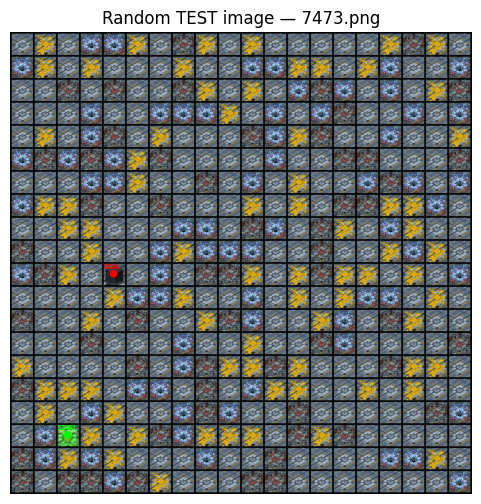

In [49]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as T

test_img_dir = f"{BASE}/test/images"
test_files = sorted(os.listdir(test_img_dir))

# Pick a random TEST image every run
test_id = random.choice(test_files)

# Load image
img = cv2.imread(f"{test_img_dir}/{test_id}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

H, W, _ = img.shape

# Predict terrain
terrain_pred = predict_terrain(img)
print("TEST image:", test_id)
print("Predicted terrain:", terrain_name[terrain_pred])

# Select tile CNN
tile_model = tile_models[terrain_pred]

# Predict tile grid
grid_logits = predict_tile_grid(img, tile_model)

# Enforce START & GOAL
pred_grid, start_pos, goal_pos = enforce_start_goal(grid_logits)

print("START position:", start_pos)
print("GOAL position :", goal_pos)

# -----------------------------
# VISUAL OVERLAY
# -----------------------------

vis = img.copy()

tile_h = H // 20
tile_w = W // 20

def tile_center(r, c):
    cy = int((r + 0.5) * tile_h)
    cx = int((c + 0.5) * tile_w)
    return cx, cy

# START (green)
sx, sy = tile_center(*start_pos)
cv2.circle(vis, (sx, sy), 12, (0, 255, 0), -1)
cv2.putText(
    vis, "START",
    (sx - 30, sy - 15),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.6, (0, 255, 0), 2
)

# GOAL (red)
gx, gy = tile_center(*goal_pos)
cv2.circle(vis, (gx, gy), 12, (255, 0, 0), -1)
cv2.putText(
    vis, "GOAL",
    (gx - 28, gy - 15),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.6, (255, 0, 0), 2
)

plt.figure(figsize=(6,6))
plt.imshow(vis)
plt.title(f"Random TEST image — {test_id}")
plt.axis("off")
plt.show()


In [50]:
BASE_COST = {
    "desert": {
        0: 1.0,     # walkable
        1: 1e9,     # wall (blocked)
        2: 3.5,     # hazard
        3: 1.0,     # start
        4: 1.0      # goal
    },
    "lab": {
        0: 1.2,
        1: 1e9,
        2: 4.0,
        3: 1.2,
        4: 1.2
    },
    "forest": {
        0: 1.4,
        1: 1e9,
        2: 4.5,
        3: 1.4,
        4: 1.4
    }
}


In [51]:
import heapq

DIRS = {
    "u": (-1, 0),
    "d": (1, 0),
    "l": (0, -1),
    "r": (0, 1),
}

def shortest_path(cost, start, goal):
    pq = []
    heapq.heappush(pq, (0, start))
    dist = {start: 0}
    parent = {}

    while pq:
        d, (r, c) = heapq.heappop(pq)

        if (r, c) == goal:
            break

        if d > dist[(r, c)]:
            continue

        for move, (dr, dc) in DIRS.items():
            nr, nc = r + dr, c + dc
            if 0 <= nr < 20 and 0 <= nc < 20:
                nd = d + cost[nr, nc]
                if nd < dist.get((nr, nc), float("inf")):
                    dist[(nr, nc)] = nd
                    parent[(nr, nc)] = ((r, c), move)
                    heapq.heappush(pq, (nd, (nr, nc)))

    # reconstruct path
    cur = goal
    path = []
    while cur != start:
        cur, move = parent[cur]
        path.append(move)

    return "".join(path[::-1])


Random TEST image: 3896.png
Predicted terrain: forest
START: (np.int64(2), np.int64(13)) GOAL: (np.int64(10), np.int64(18))
Path length: 13


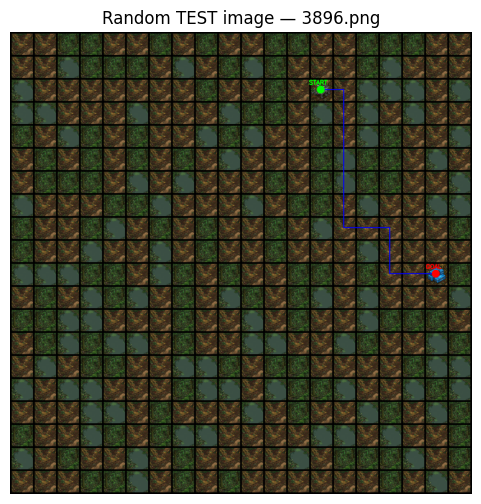

In [55]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as T

# --------------------------------
# Pick random TEST image
# --------------------------------
test_img_dir = f"{BASE}/test/images"
test_vel_dir = f"{BASE}/test/velocities"

test_files = sorted(os.listdir(test_img_dir))
test_id = random.choice(test_files)
img_id = test_id.split(".")[0]

print("Random TEST image:", test_id)

# --------------------------------
# Load image
# --------------------------------
img = cv2.imread(f"{test_img_dir}/{test_id}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
H, W, _ = img.shape

# --------------------------------
# Terrain prediction
# --------------------------------
terrain_pred = predict_terrain(img)
terrain_str = terrain_name[terrain_pred]
print("Predicted terrain:", terrain_str)

# --------------------------------
# Tile prediction
# --------------------------------
tile_model = tile_models[terrain_pred]
grid_logits = predict_tile_grid(img, tile_model)
pred_grid, start_pos, goal_pos = enforce_start_goal(grid_logits)

print("START:", start_pos, "GOAL:", goal_pos)

# --------------------------------
# Load velocity
# --------------------------------
with open(f"{test_vel_dir}/{img_id}.json") as f:
    boost = np.array(json.load(f)["boost"])

# --------------------------------
# Build cost grid
# --------------------------------
cost = np.zeros((20, 20))
for r in range(20):
    for c in range(20):
        cls = pred_grid[r, c]
        cost[r, c] = BASE_COST[terrain_str][cls] - boost[r, c]

# --------------------------------
# Shortest path
# --------------------------------
path = shortest_path(cost, start_pos, goal_pos)
print("Path length:", len(path))

# --------------------------------
# Convert path to coordinates
# --------------------------------
path_coords = [start_pos]
r, c = start_pos
for move in path:
    if move == "u": r -= 1
    elif move == "d": r += 1
    elif move == "l": c -= 1
    elif move == "r": c += 1
    path_coords.append((r, c))

# --------------------------------
# Visualization
# --------------------------------
vis = img.copy()
tile_h = H // 20
tile_w = W // 20

def tile_center(r, c):
    return int((c + 0.5) * tile_w), int((r + 0.5) * tile_h)

# Draw path
for i in range(len(path_coords) - 1):
    p1 = tile_center(*path_coords[i])
    p2 = tile_center(*path_coords[i + 1])
    cv2.line(vis, p1, p2, (0, 0, 255), 2)

# Draw START
sx, sy = tile_center(*start_pos)
cv2.circle(vis, (sx, sy), 12, (0, 255, 0), -1)
cv2.putText(vis, "START", (sx - 35, sy - 15),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

# Draw GOAL
gx, gy = tile_center(*goal_pos)
cv2.circle(vis, (gx, gy), 12, (255, 0, 0), -1)
cv2.putText(vis, "GOAL", (gx - 30, gy - 15),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

# Show
plt.figure(figsize=(6,6))
plt.imshow(vis)
plt.title(f"Random TEST image — {test_id}")
plt.axis("off")
plt.show()


TEST image: 0004.png
Predicted terrain: desert
START: (np.int64(14), np.int64(8))
GOAL : (np.int64(16), np.int64(4))
Path length: 6


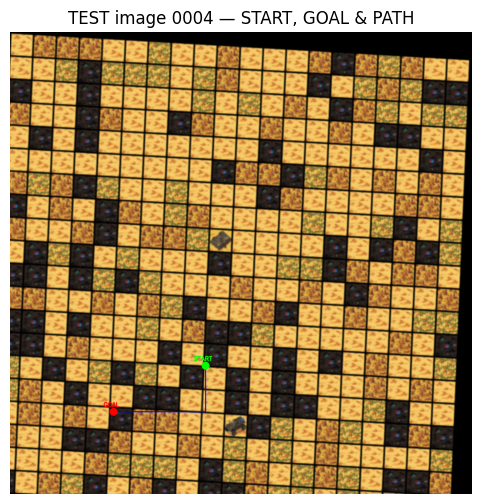

In [56]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# --------------------------------
# Fixed TEST image
# --------------------------------
test_id = "0004.png"
img_id = "0004"

test_img_dir = f"{BASE}/test/images"
test_vel_dir = f"{BASE}/test/velocities"

print("TEST image:", test_id)

# --------------------------------
# Load image
# --------------------------------
img = cv2.imread(f"{test_img_dir}/{test_id}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
H, W, _ = img.shape

# --------------------------------
# Terrain prediction
# --------------------------------
terrain_pred = predict_terrain(img)
terrain_str = terrain_name[terrain_pred]
print("Predicted terrain:", terrain_str)

# --------------------------------
# Tile prediction
# --------------------------------
tile_model = tile_models[terrain_pred]
grid_logits = predict_tile_grid(img, tile_model)
pred_grid, start_pos, goal_pos = enforce_start_goal(grid_logits)

print("START:", start_pos)
print("GOAL :", goal_pos)

# --------------------------------
# Load velocity
# --------------------------------
with open(f"{test_vel_dir}/{img_id}.json") as f:
    boost = np.array(json.load(f)["boost"])

# --------------------------------
# Build cost grid
# --------------------------------
cost = np.zeros((20, 20))
for r in range(20):
    for c in range(20):
        cls = pred_grid[r, c]
        cost[r, c] = BASE_COST[terrain_str][cls] - boost[r, c]

# --------------------------------
# Shortest path
# --------------------------------
path = shortest_path(cost, start_pos, goal_pos)
print("Path length:", len(path))

# --------------------------------
# Convert path to coordinates
# --------------------------------
path_coords = [start_pos]
r, c = start_pos
for move in path:
    if move == "u": r -= 1
    elif move == "d": r += 1
    elif move == "l": c -= 1
    elif move == "r": c += 1
    path_coords.append((r, c))

# --------------------------------
# Visualization
# --------------------------------
vis = img.copy()
tile_h = H // 20
tile_w = W // 20

def tile_center(r, c):
    return int((c + 0.5) * tile_w), int((r + 0.5) * tile_h)

# Draw path
for i in range(len(path_coords) - 1):
    p1 = tile_center(*path_coords[i])
    p2 = tile_center(*path_coords[i + 1])
    cv2.line(vis, p1, p2, (0, 0, 255), 2)

# Draw START
sx, sy = tile_center(*start_pos)
cv2.circle(vis, (sx, sy), 12, (0, 255, 0), -1)
cv2.putText(
    vis, "START",
    (sx - 35, sy - 15),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.6, (0, 255, 0), 2
)

# Draw GOAL
gx, gy = tile_center(*goal_pos)
cv2.circle(vis, (gx, gy), 12, (255, 0, 0), -1)
cv2.putText(
    vis, "GOAL",
    (gx - 30, gy - 15),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.6, (255, 0, 0), 2
)

# Show result
plt.figure(figsize=(6, 6))
plt.imshow(vis)
plt.title("TEST image 0004 — START, GOAL & PATH")
plt.axis("off")
plt.show()


In [57]:
import pandas as pd

submission = []

test_img_dir = f"{BASE}/test/images"
test_vel_dir = f"{BASE}/test/velocities"
test_files = sorted(os.listdir(test_img_dir))

total = len(test_files)
print("Total test images:", total)

for idx, fname in enumerate(test_files):
    # Progress logging
    if idx % 1000 == 0:
        print(f"Processed {idx}/{total} images")

    img_id = fname.split(".")[0]

    # Load image
    img = cv2.imread(f"{test_img_dir}/{fname}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Predict terrain
    terrain_pred = predict_terrain(img)
    terrain_str = terrain_name[terrain_pred]

    # Select tile CNN
    tile_model = tile_models[terrain_pred]

    # Predict tiles
    grid_logits = predict_tile_grid(img, tile_model)
    pred_grid, start_pos, goal_pos = enforce_start_goal(grid_logits)

    # Load velocity
    with open(f"{test_vel_dir}/{img_id}.json") as f:
        boost = np.array(json.load(f)["boost"])

    # Build cost grid
    cost = np.zeros((20, 20))
    for r in range(20):
        for c in range(20):
            cls = pred_grid[r, c]
            cost[r, c] = BASE_COST[terrain_str][cls] - boost[r, c]

    # Shortest path
    path = shortest_path(cost, start_pos, goal_pos)

    submission.append({
        "image_id": img_id,
        "path": path
    })

# Final log
print(f"Processed {total}/{total} images")

# Write CSV
df = pd.DataFrame(submission)
df.to_csv("submission.csv", index=False)

print("submission.csv generated successfully")


Total test images: 10000
Processed 0/10000 images
Processed 1000/10000 images
Processed 2000/10000 images
Processed 3000/10000 images
Processed 4000/10000 images
Processed 5000/10000 images
Processed 6000/10000 images
Processed 7000/10000 images
Processed 8000/10000 images
Processed 9000/10000 images
Processed 10000/10000 images
submission.csv generated successfully
